# Check sync process

In [2]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [3]:
import datetime
import pathlib
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


from u19_pipeline.ephys_pipeline import ephys_element, probe_element, get_session_directory, get_ephys_root_data_dir
# import u19_pipeline.ephys_sync as ephys
import u19_pipeline.acquisition as acquisition
import datajoint as dj

from element_interface.utils import find_full_path

import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX
import u19_pipeline.utils.ephys_utils as ephys_utils


c:\Users\luna_\miniconda3\envs\u19_pipeline_python_env\Lib\site-packages\datajoint\plugin.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Users\luna_\miniconda3\envs\u19_pipeline_python_env\Lib\site-packages\datajoint\plugin.py:4: UserWarning: Module scripts was already imported from None, but c:\users\luna_\documents\princetonprojects\u19-pipeline-python is being added to sys.path
  import pkg_resources
[2025-10-17 17:59:32,042][INFO]: DataJoint 0.14.6 connected to alvaros@datajoint00.pni.princeton.edu:3306


In [4]:
key = {'subject_fullname': 'jyanar_ya054',
    'session_date': datetime.date(2025, 10, 11)}
#key = {
#    'subject_fullname': 'jjulian_jj046',
#    'session_date': datetime.date(2022, 4, 19)}

#key2 = 'subject_fullname = "jjulian_jj046" and session_date = "2022-04-19" and block >=2'
#key = {
#    'subject_fullname': 'jjulian_jj042',
#    'session_date': datetime.date(2021, 10, 31)}


key = (acquisition.Session & key).fetch1('KEY')
key

recording = dj.create_virtual_module('recording', 'u19_recording')

recording_key = ((acquisition.Session * recording.Recording.BehaviorSession) & key).fetch('recording_id', as_dict=True)
recording_key

[{'recording_id': np.int64(500)}]

In [ ]:
session_dir = pathlib.Path(get_session_directory(recording_key[0]))
session_dir


WindowsPath('jyanar/jyanar_ya054/20251011_g0/ya054_20251011_g0')

: 

In [ ]:
session_dir = find_full_path(get_ephys_root_data_dir(),
                            get_session_directory(recording_key))
print(session_dir)
#session_dir = pathlib.Path('/Users/alvaros/Documents/MATLAB/BrainCogsProjects/CalciumImagingData/test_g0/')
#Check if session is Nidq or OneBox
nidq_session = list(session_dir.glob('*nidq.bin*'))
obx_session = list(session_dir.glob('*obx.bin*'))

if len(nidq_session) == 0 and len(obx_session) == 0:
    print('No session found')
elif len(nidq_session) > 0:
    ephys_session_fullpath = nidq_session[0]
else:
    ephys_session_fullpath = obx_session[0]

#Nidaq file
nidq_meta          = readSGLX.readMeta(ephys_session_fullpath)
nidq_sampling_rate = readSGLX.SampRate(nidq_meta)


# 1: load meta data, and the content of the NIDAQ file. Its content is digital.            
new_trial_channel = 1
new_iteration_channel = 2
# If PXIe card (nidq) card use for recording deduce digital channels
if nidq_meta['typeThis'] == 'nidq':
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta)
# If onebox card (obx) card use for recording digital channels are 0-2
else:
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta, d_line_list=[0,1])
    # If no sync pulse found trial and iteration signals are 0 & 1 respectively
    new_trial_channel = 0
    new_iteration_channel = 1

\\cup.pni.princeton.edu\braininit\Data\Raw\electrophysiology\jyanar\jyanar_ya054\20251011_g0\ya054_20251011_g0
nChan: 4, nFileSamp: 111367791


# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

### Read nidaq file and behavior data

In [ ]:
#Behavior data
behavior = dj.create_virtual_module('behavior', 'u19_behavior')
thissession = behavior.TowersBlock().Trial() & key
behavior_time, iterstart, beh_num_iterations = thissession.fetch('trial_time', 'vi_start', 'iterations')


In [ ]:
behavior_time.shape

(282,)

In [7]:
print(nidq_meta)

{'acqMnMaXaDw': '0,0,0,1', 'appVersion': '20231207', 'fileCreateTime': '2025-09-25T11:25:18', 'fileName': 'D:/NPX_DATA/jk8386/jk8386_jk86/jk86_20250925_g0/jk86_20250925_g0_t0.nidq.bin', 'fileSHA1': '9682B81358798B79D687DEDEFA1BA99920DEA3A9', 'fileSizeBytes': '37740126', 'fileTimeSecs': '3773.9652676824057', 'firstSample': '8254553', 'gateMode': 'Immediate', 'imErrFlags0_IS_CT_SR_LK_PP_SY': '0 0 0 0 0 0', 'nDataDirs': '1', 'nSavedChans': '1', 'niAiRangeMax': '5', 'niAiRangeMin': '-5', 'niAiTermination': 'Default', 'niClockLine1': 'Internal', 'niClockSource': 'PXI1Slot4_13ch_Int : 5000.000000', 'niDev1': 'PXI1Slot4', 'niDev1ProductName': 'PXIe-6341', 'niMAChans1': '', 'niMAGain': '1', 'niMNChans1': '', 'niMNGain': '200', 'niMaxInt': '32768', 'niMuxFactor': '32', 'niSampRate': '5000.062709', 'niStartEnable': 'false', 'niStartLine': 'PXI1Slot4/port0/line0', 'niXAChans1': '', 'niXDBytes1': '1', 'niXDChans1': '0:7', 'snsMnMaXaDw': '0,0,0,1', 'snsSaveChanSubset': 'all', 'syncNiChan': '0', 'sy

In [9]:
digital_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(2, 111367791), dtype=uint8)

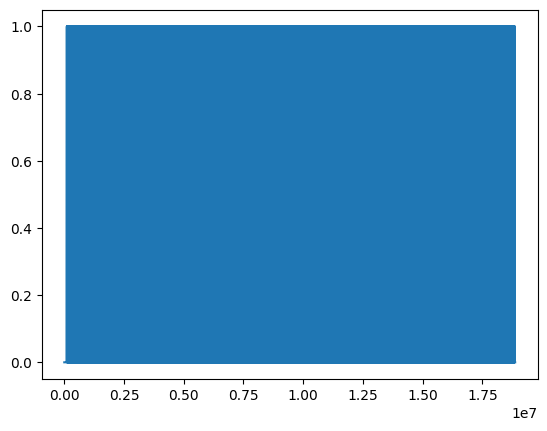

In [18]:
plt.plot(digital_array[1,:])

In [10]:
digital_array.shape

(2, 111367791)

### Get samples and times where trials and iterations start

In [12]:
mode = None   #Default for sessions before 12/01/2021
#mode = 'pulses'    #Default for sessions after 12/01/2021
iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(digital_array[new_trial_channel,:], digital_array[new_iteration_channel,:], nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode=mode)
#                             get_iteration_sample_vector_from_digital_lines_pulses(trial_pulse_signal, iteration_pulse_signal,


# Check # of trials and iterations match
trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

print(trial_count_diff)
print(trials_diff_iteration_big)
print(trials_diff_iteration_small)


status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small)


IndexError: index 2 is out of bounds for axis 0 with size 2

In [7]:
iteration_dict.keys()

dict_keys(['framenumber_vector_samples', 'trialnumber_vector_samples', 'iter_start_idx', 'iter_times_idx'])

In [11]:
it_times = iteration_dict['iter_times_idx'][trials_diff_iteration_small[0]]
beh_times = behavior_time[trials_diff_iteration_small[0]].flatten()

In [16]:
if it_times.shape[0] >= beh_times.shape[0]:
    print('More pulses than behavior iterations, check other method')
else:
    diff_vector = np.diff(it_times - beh_times[:it_times.shape[0]])

import scipy
peaks, _ = scipy.signal.find_peaks(diff_vector, height=0.05, distance=20)
peaks

array([658, 734])

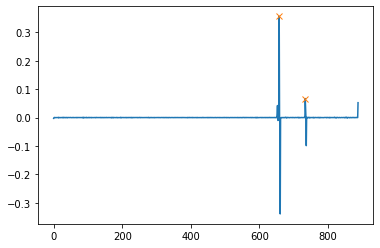

In [14]:
plt.plot(diff_vector)
plt.plot(peaks, diff_vector[peaks], "x")
plt.show()

In [21]:
difo_iters = np.diff(iteration_dict['iter_start_idx'][trials_diff_iteration_small[0]])
peaks2, _ = scipy.signal.find_peaks(difo_iters, height=1500, distance=20)

In [24]:
original_iter = iteration_dict['iter_start_idx'][trials_diff_iteration_small[0]]
new_iter_start = iteration_dict['iter_start_idx'][trials_diff_iteration_small[0]]

for i in range(peaks.shape[0]):
    value_insert = (original_iter[peaks[i]] + original_iter[peaks[i]+1] ) /2
    new_iter_start = np.insert(new_iter_start, peaks[i], value_insert)


if new_iter_start.shape[0] != beh_times[:it_times.shape[0]]:
    print('with peak strategy, could not find correct missing iterations')


892

In [30]:
so = np.empty(0)
so.shape

(0,)

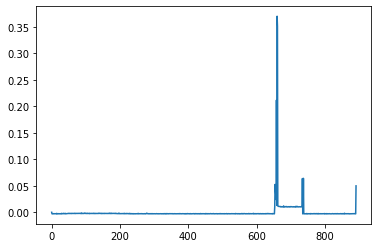

In [25]:
times = new_iter_start/nidq_sampling_rate
times = times - times[0]
new_diff_times = times - beh_times
plt.plot(new_diff_times)

In [28]:
beh_times[-5:]

array([12.291347, 12.304482, 12.31789 , 12.331045, 12.344059],
      dtype=float32)

In [22]:
print(iteration_dict.keys())
so = np.where(iteration_dict['trialnumber_vector_samples'] == 12)

print(so[0])


dict_keys(['framenumber_vector_samples', 'trialnumber_vector_samples', 'iter_start_idx', 'iter_times_idx'])
[1212738 1212739 1212740 ... 1292073 1292074 1292075]


### Plot signals around start of a trial

time from niDAQ 41.01721652828713
time behavior [40.958096]
samples nidaq 1025429
iter nidaq (2705,)
iter_virmen (2704, 1)


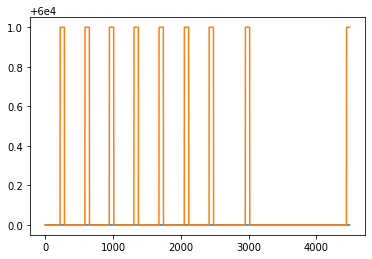

In [41]:
trial_plot = 280
samp_before = 3000
start_iter = 2704
end_iter = 2704
samp_after = 60000

plt.plot(digital_array[1,iteration_dict['iter_start_idx'][trial_plot][start_iter]-samp_before:iteration_dict['iter_start_idx'][trial_plot][end_iter]]+samp_after)
plt.plot(digital_array[2,iteration_dict['iter_start_idx'][trial_plot][start_iter]-samp_before:iteration_dict['iter_start_idx'][trial_plot][end_iter]]+samp_after)


iter_nidaq = (iteration_dict['iter_start_idx'][trial_plot][-1]-iteration_dict['iter_start_idx'][trial_plot][0])
time = iter_nidaq/nidq_sampling_rate
iter_virmen = time*120

print('time from niDAQ', time)
print('time behavior', behavior_time[trial_plot][-1])

print('samples nidaq', iter_nidaq)
print('iter nidaq', iteration_dict['iter_start_idx'][trial_plot].shape)
print('iter_virmen',behavior_time[trial_plot].shape)

time from niDAQ 41.01721652828713
time behavior [40.958096]
samples nidaq 1025429
iter nidaq (2705,)
iter_virmen (2704, 1)


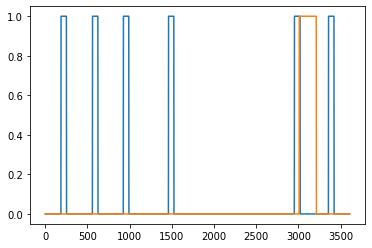

In [54]:
trial_plot = 280
samp_before = 3000
start_iter = 2704
samp_after = 600

plt.plot(digital_array[2,iteration_dict['iter_start_idx'][trial_plot][start_iter]-samp_before:iteration_dict['iter_start_idx'][trial_plot+1][0]+samp_after])
plt.plot(digital_array[1,iteration_dict['iter_start_idx'][trial_plot][start_iter]-samp_before:iteration_dict['iter_start_idx'][trial_plot+1][0]+samp_after])


iter_nidaq = (iteration_dict['iter_start_idx'][trial_plot][-1]-iteration_dict['iter_start_idx'][trial_plot][0])
time = iter_nidaq/nidq_sampling_rate
iter_virmen = time*120

print('time from niDAQ', time)
print('time behavior', behavior_time[trial_plot][-1])

print('samples nidaq', iter_nidaq)
print('iter nidaq', iteration_dict['iter_start_idx'][trial_plot].shape)
print('iter_virmen',behavior_time[trial_plot].shape)

In [44]:
trial_plot = 280
print(iteration_dict['iter_start_idx'][trial_plot][2704])
print(iteration_dict['iter_start_idx'][trial_plot+1][0])

97225703
97225711


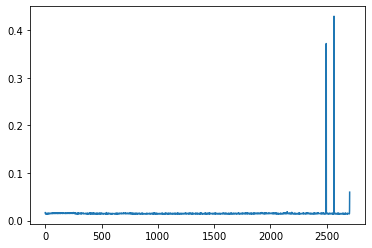

In [23]:
plt.plot(np.diff(iteration_dict['iter_start_idx'][trial_plot]/nidq_sampling_rate))

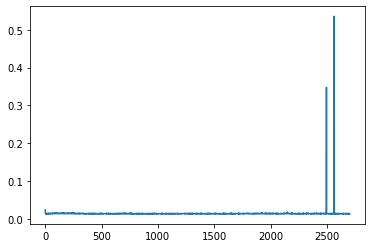

In [36]:
plt.plot(np.diff(behavior_time[trial_plot].flatten()))

In [34]:
print(behavior_time[trial_plot].flatten())

[0.0000000e+00 2.4555599e-02 3.8950201e-02 ... 4.0928226e+01 4.0943489e+01
 4.0958096e+01]


### Plot average time differences between behavior file and nidaq time

In [18]:
x = np.array([])
mean_x = np.array([])
for i in range(iteration_dict['iter_times_idx'].shape[0]-1):
    s = behavior_time[i].flatten()-iteration_dict['iter_times_idx'][i]
    mean_time_trial = np.mean(s)
    x = np.append(x,s, axis=0)
    mean_x = np.append(mean_x, mean_time_trial)

#plt.plot(x)
plt.plot(mean_x)


ValueError: operands could not be broadcast together with shapes (2704,) (2705,) 

### Test BehaviorSync insertion

In [4]:
ephys.BehaviorSync.populate(key)

nChan: 1, nFileSamp: 18400502
1
1436
1436
2
1337
1337
3
1201
1201
4
1147
1147
5
1017
1017
6
1171
1171
7
1778
1778
8
1725
1725
9
1285
1285
10
935
935
11
1008
1008
12
904
904
13
1149
1149
14
1105
1105
15
976
976
16
1210
1210
17
1088
1088
18
1090
1090
19
1190
1190
20
1025
1025
21
1645
1645
22
1816
1816
23
1859
1859
24
1854
1854
25
1630
1630
26
1022
1022
27
1048
1048
28
997
997
29
1080
1080
30
979
979
31
1047
1047
32
1021
1021
33
1022
1022
34
1082
1082
35
1105
1105
36
1013
1013
37
1786
1786
38
3131
3131
39
985
985
40
1150
1150
41
3314
3314
42
1003
1003
43
1670
1670
44
1713
1713
45
1750
1750
46
1780
1780
47
1750
1750
48
1108
1108
49
1609
1609
50
1312
1312
51
1662
1662
52
1458
1458
53
1049
1049
54
1124
1124
55
1625
1625
56
1339
1339
57
1083
1083
58
1104
1104
59
1046
1046
60
1289
1289
61
1180
1180
62
1167
1167
63
1102
1102
64
1784
1784
65
2114
2114
66
1514
1514
67
1145
1145
68
1056
1056
69
1020
1020
70
1002
1002
71
1206
1206
72
1036
1036
73
1057
1057
74
1000
1000
75
1066
1066
76
1114
1114
77


In [5]:
ephys.BehaviorSync()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,nidq_sampling_rate sampling rate of behavioral iterations niSampRate in nidq meta file,iteration_index_nidq length of this longblob should be the number of iterations in the behavior recording,trial_index_nidq length of this longblob should be the number of iterations in the behavior recording
hnieh_E105,2021-01-15,0,5000.08,=BLOB=,=BLOB=
jjulian_jj042,2021-10-31,0,5000.06,=BLOB=,=BLOB=
jjulian_jj042,2021-11-01,0,5000.06,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-14,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-15,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-16,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-17,0,5000.06,=BLOB=,=BLOB=
jjulian_jj049,2022-01-14,0,5000.06,=BLOB=,=BLOB=
jjulian_jj049,2022-01-15,0,5000.06,=BLOB=,=BLOB=
